<h1 align=center><font size = 6>CAPSTONE PROJECT</font></h1>
<h1 align=center><font size = 5>Identify best locations to open a shop in a city</font></h1>


# Problem statement

### In this project I explore the Toronto neighborhoods and identify the potential locations to open a _sporting goods shop_. 
#### For this purpose I consider the following criterion:
- Identify neighborhoods with a high density of sport venues because such neighborhoods bring more customers for the new shop.
- Consider neighborhoods with more shopping centers (mall or shopping plaza). Assume we are planning to open the shop in an existing shopping center. 
- Select neighborhoods where there is not similar shops.

#### Data collection sources:
- Use Foursquare API to obtain data about venues
- Scrape neighborhoods information of the city from wikipedia (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)
- Obtain geospacial information of the neighborhoods from (http://cocl.us/Geospatial_data)

#### Methodology: 
 1. Collect and clean data for different neighborhoods of Toronto including their geospacial information
 2. Use Foursquare API to obtain venues data for each neighborhood
 3. Preprocess the data and performa exploratory data analysis to better explore and understand the data
 5. Find the number of sporting venues, existing sport shops and shopping centers in each neighborhoods
 4. Use K-means clustering method to cluster the neighborhoods based on the number of sporting venues and shopping centers
 5. Explore to clusters and identify potential neighborhoods

#### Utilized packages:
 - Programming language (Python)
 - Libraries: sklearn, pandas, numpy, requests, BeautifulSoup, geopy, matplotlib, folium, seaborn

### Import required libraries

In [1]:
import numpy as np
import pandas as pd
import json 
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import matplotlib.colors as colors 
from matplotlib import pyplot as plt
from collections import Counter # count occurrences 
from sklearn.cluster import KMeans
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
np.random.seed(24510) # use a random seed

## Collecting and processing the data

### 1-Scrape Toronto neighbourhood information and create a dataframe

#### Scrape the data from wikipedia

In [2]:
# read the webpage
address='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
content=requests.get(address)
#content.text
soup=BeautifulSoup(content.text,'xml')
table=soup.find('table')
#print(table.prettify())
td=table.find_all('td')
Postalcode=[]
Borough=[]
Neighborhood=[]
for i in range(0,len(td),3):
    Postalcode.append(td[i].text.strip())
    Borough.append(td[i+1].text.strip())
    Neighborhood.append(td[i+2].text.strip())

#### Create a dataframe with the city information

In [3]:
# create a data table
df=pd.DataFrame([Postalcode,Borough,Neighborhood]).transpose()
df.columns=['Postalcode','Borough','Neighborhood']

#### Clean up the data

In [4]:
# drop the rows with Borough == 'Not assigned'
df.drop(df[df['Borough']=="Not assigned"].index,axis=0, inplace=True)

Note: If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.

In [5]:
df.loc[df['Neighborhood']=='Not assigned','Neighborhood']=df.loc[df['Neighborhood']=='Not assigned','Borough']
# reset index
df = df.reset_index(drop=True)
df.head(10)

,Postalcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


### 2- Add Geospatial information to the data frame

#### Get Toronto geospacial information from http://cocl.us/Geospatial_data

In [6]:
df_geospacial = pd.read_csv('http://cocl.us/Geospatial_data')
# rename 'Postal Code' to 'Postalcode'
df_geospacial.rename(columns={'Postal Code':'Postalcode'}, inplace=True)
# Add the Geospatial data to the neighborhood dataframe
# merge df and df_df_geospacial
df=df.merge(right=df_geospacial,how='inner',on='Postalcode')
df.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


### 3- Save the data in a csv file

In [7]:
df.to_csv('Toronto_neighborhoods_WithGeospacial.csv',index=False)

## Explore Toronto neighborhoods areas

In [8]:
df.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [9]:
print('The dataframe has {} boroughs and {} Neighborhood.'.format(
        len(df['Borough'].unique()),
        df.shape[0]
    )
)

The dataframe has 10 boroughs and 103 Neighborhood.


#### Use geopy library to get the latitude and longitude values of Toronto.

In [10]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


### Create a map of Toronto with Neighborhoods superimposed on top.

In [11]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'],\
                                           df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

#### Define Foursquare Credentials and Version

In [12]:
#Cred_data=pd.read_csv('Credentials.csv')
CLIENT_ID='0U33ZOD3LSQU3KWWOCISFB3POET3KLFBY1JHEBCPRO2JLQVA'#Cred_data['CLIENT_ID'][0]
CLIENT_SECRET='XEFAWTZMZ1H5ETGEO1PSWY5U02HLD4WIS0AQQMJMMSGA4PFV'#Cred_data['CLIENT_SECRET'][0]
VERSION='20200505'
LIMIT=30

#### Fetch Foursquare Venue Category Hierarchy

In [13]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
category_results = requests.get(url).json()

In [14]:
with open('category_results.json', 'w') as f:
    json.dump(category_results, f)

In [15]:
for key, value in category_results['response']['categories'][0].items():
    print(key, len(str(value)))

id 24
name 20
pluralName 20
shortName 20
icon 98
categories 16373


In [16]:
category_list = category_results['response']['categories']
len(category_list)

10

In [17]:
for data in category_list:
    print(data['id'], data['name'])

4d4b7104d754a06370d81259 Arts & Entertainment
4d4b7105d754a06372d81259 College & University
4d4b7105d754a06373d81259 Event
4d4b7105d754a06374d81259 Food
4d4b7105d754a06376d81259 Nightlife Spot
4d4b7105d754a06377d81259 Outdoors & Recreation
4d4b7105d754a06375d81259 Professional & Other Places
4e67e38e036454776db1fb3a Residence
4d4b7105d754a06378d81259 Shop & Service
4d4b7105d754a06379d81259 Travel & Transport


In [18]:
# category id of 'Outdoors & Recreation' 
Sport_ID='4d4b7105d754a06377d81259'
# category id of 'Shop & Service'
Shop_ID='4d4b7105d754a06378d81259'

#### Explore _Outdoors & Recreation_ & It's Sub-Categories

Let's create a function to return a dictionary with Ids' & Names of _Outdoors & Recreation_ & It's Sub-Categories.

In [19]:
# function to flatten a 'parent_id' category, returns all categories if checkParentID = False
def flatten_Hierarchy(category_list, checkParentID, category_dict, parent_id = ''):
    for data in category_list:
        
        if checkParentID == True and data['id'] == parent_id:
            category_dict[data['id']] = data['name']
            flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
        
        elif checkParentID == False:
            category_dict[data['id']] = data['name']
            if len(data['categories']) != 0:
                flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
    
    return category_dict

In [20]:
# this function takes the parent ID and returns 'name' and 'id' of all the sub-categories
category_dict = flatten_Hierarchy(category_list, checkParentID=True, category_dict = {}, parent_id = Sport_ID)
category_dict

{'4d4b7105d754a06377d81259': 'Outdoors & Recreation',
 '4f4528bc4b90abdf24c9de85': 'Athletics & Sports',
 '52e81612bcbc57f1066b7a2b': 'Badminton Court',
 '4bf58dd8d48988d1e8941735': 'Baseball Field',
 '4bf58dd8d48988d1e1941735': 'Basketball Court',
 '52e81612bcbc57f1066b7a2f': 'Bowling Green',
 '56aa371be4b08b9a8d57351a': 'Curling Ice',
 '4bf58dd8d48988d1e6941735': 'Golf Course',
 '58daa1558bbb0b01f18ec1b0': 'Golf Driving Range',
 '4bf58dd8d48988d175941735': 'Gym / Fitness Center',
 '52f2ab2ebcbc57f1066b8b47': 'Boxing Gym',
 '503289d391d4c4b30a586d6a': 'Climbing Gym',
 '52f2ab2ebcbc57f1066b8b49': 'Cycle Studio',
 '4bf58dd8d48988d105941735': 'Gym Pool',
 '52f2ab2ebcbc57f1066b8b48': 'Gymnastics Gym',
 '4bf58dd8d48988d176941735': 'Gym',
 '4bf58dd8d48988d101941735': 'Martial Arts School',
 '58daa1558bbb0b01f18ec203': 'Outdoor Gym',
 '5744ccdfe4b0c0459246b4b2': 'Pilates Studio',
 '4bf58dd8d48988d106941735': 'Track',
 '590a0744340a5803fd8508c3': 'Weight Loss Center',
 '4bf58dd8d48988d1029417

#### Explore the first Neighborhood to understand the results of GET Request

Get the Neighborhood's name.

In [21]:
df.loc[0, 'Neighborhood']

'Parkwoods'

Get the Neighborhood's latitude and longitude values.

In [22]:
neighborhood_latitude = df.loc[0, 'Latitude'] # Neighborhood area latitude value
neighborhood_longitude = df.loc[0, 'Longitude'] # Neighborhood area longitude value

neighborhood_name = df.loc[0, 'Postalcode'] # postalcode name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of M3A are 43.7532586, -79.3296565.


#### Get the _Sport & Recreation_ that is in this neighborhood within a radius of one mile or ~1610 meters.

Create the GET request URL to search for Venue with requested _Category ID_

In [23]:
LIMIT = 500 # limit of number of venues returned by Foursquare API
radius = 1610 # define radius
categoryId = Sport_ID # category ID for "sport and recreation"
# create URL

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    categoryId,
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/search?&client_id=0U33ZOD3LSQU3KWWOCISFB3POET3KLFBY1JHEBCPRO2JLQVA&client_secret=XEFAWTZMZ1H5ETGEO1PSWY5U02HLD4WIS0AQQMJMMSGA4PFV&v=20200505&ll=43.7532586,-79.3296565&radius=1610&categoryId=4d4b7105d754a06377d81259&limit=500'

Send the GET request and examine the resutls

In [24]:
results = requests.get(url).json()

In [25]:
results['response']['venues'][0]

{'id': '4e8d9dcdd5fbbbb6b3003c7b',
 'name': 'Brookbanks Park',
 'location': {'address': 'Toronto',
  'lat': 43.751976046055574,
  'lng': -79.33214044722958,
  'labeledLatLngs': [{'label': 'display',
    'lat': 43.751976046055574,
    'lng': -79.33214044722958}],
  'distance': 245,
  'cc': 'CA',
  'city': 'Toronto',
  'state': 'ON',
  'country': 'Canada',
  'formattedAddress': ['Toronto', 'Toronto ON', 'Canada']},
 'categories': [{'id': '4bf58dd8d48988d163941735',
   'name': 'Park',
   'pluralName': 'Parks',
   'shortName': 'Park',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/park_',
    'suffix': '.png'},
   'primary': True}],
 'venuePage': {'id': '600917367'},
 'referralId': 'v-1612193571',
 'hasPerk': False}

### In a simillar manner we can obtain information about 'Shop & Service' venues

### Since our goal is to segment the neighborhoods of Toronto with respect to the _Sport & Recreation_ and _Shop & Service_ venues in their vicinities. We need to proceed further to fetch this data for all neighborhoods' venues.

#### Let's create a function to repeat the following process to all the postalcode areas in Toronto:
* Loop through postalcodes
    * Create the API request URL with radius=1610, LIMIT=500
    * Make the GET request
    * For each postalcode, return only relevant information for each nearby venue
    * Append all nearby venues to a list
* Unfold the list & append it to dataframe being returned

In [26]:
def getNearbyVenues(ID, names, latitudes, longitudes, radius=1610, LIMIT=500):
    not_found = 0
    print('***Start ', end='')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            ID, # category id
            LIMIT)
            
        try:
            # make the GET request
            results = requests.get(url).json()['response']['venues']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name']) for v in results])
        except:
            not_found += 1


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print("\nDone*** with {} venues with incompelete information.".format(not_found))
    return(nearby_venues)

Use pickle library to serialize the information retrieved from GET requests. This step will counter any redundant requests to the Foursquare API.

#### Gether information about _Sport & Recreation_ venues

In [27]:
import pickle # to serialize and deserialize a Python object structure

# get all sport venues
try:
    with open('Toronto_venues_sport.pkl', 'rb') as f:
        Toronto_venues_sport = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")
except:
    Toronto_venues_sport = getNearbyVenues(ID=Sport_ID, names=df['Neighborhood'],
                                        latitudes=df['Latitude'],
                                        longitudes=df['Longitude']
                                       )
    with open('Toronto_venues_sport.pkl', 'wb') as f:
        pickle.dump(Toronto_venues_sport, f)
    print("---Dataframe Created and Serialized---")

---Dataframe Existed and Deserialized---


#### Gether information about and _Shop & Service_ venues

In [28]:
# get all shop venues
try:
    with open('Toronto_venues_shop.pkl', 'rb') as f:
        Toronto_venues_shop = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")
except:
    Toronto_venues_shop = getNearbyVenues(ID=Shop_ID, names=df['Neighborhood'],
                                        latitudes=df['Latitude'],
                                        longitudes=df['Longitude']
                                       )
    with open('Toronto_venues_shop.pkl', 'wb') as f:
        pickle.dump(Toronto_venues_shop, f)
    print("---Dataframe Created and Serialized---")

---Dataframe Existed and Deserialized---


# Analysis & K-Means clustering

#### Find out how many unique categories can be curated from all the returned _Sport & Recreation_ venues

In [29]:
print('There are {} uniques categories.'.format(len(Toronto_venues_sport['Venue Category'].unique())))
Toronto_venues_sport.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 102 uniques categories.


Venue Category
Park                                        1063
Gym                                          418
Playground                                   249
Gym / Fitness Center                         246
Other Great Outdoors                         182
Athletics & Sports                           139
Garden                                       129
Pool                                         122
Trail                                        106
Skating Rink                                 101
Dog Run                                       98
Yoga Studio                                   88
Martial Arts Dojo                             81
Tennis Court                                  79
Bridge                                        78
Baseball Field                                78
Plaza                                         66
Harbor / Marina                               61
Field                                         59
Scenic Lookout                                45
Socce

#### Manually create a list of desired sport categories

In [30]:
sport_categories = ['Gym','Gym / Fitness Center','Athletics & Sports','Pool','Skating Rink','Baseball Field',
                    'Tennis Court','Martial Arts Dojo','Yoga Studio','Golf Course','Soccer Field',
                    'Pilates Studio','Skate Park','Recreation Center','Outdoors & Recreation','Basketball Court',
                    'Gym Pool','Sports Club','Hockey Arena','Boxing Gym','Ski Area','Badminton Court',
                    'College Stadium','Climbing Gym','Hockey Rink','Curling Ice','Hockey Field','Stadium',
                    'Rock Climbing Spot','Volleyball Court','Paintball Field','College Rec Center','Gymnastics Gym']

Revise the results to keep only venues in the list of sport categories

In [31]:
Toronto_venues_sport = Toronto_venues_sport[Toronto_venues_sport['Venue Category'].isin(sport_categories)].reset_index()
Toronto_venues_sport.head(5)

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,Parkwoods,43.753259,-79.329656,GoodLife Fitness North York Victoria Terrace,43.742128,-79.314590,Gym
1,2,Parkwoods,43.753259,-79.329656,GH20,43.765608,-79.342918,Gym / Fitness Center
2,4,Parkwoods,43.753259,-79.329656,Pheasant Run Golf Course,43.758386,-79.337191,Golf Course
3,5,Parkwoods,43.753259,-79.329656,West Ellesmere Community Gym,43.758155,-79.307618,Athletics & Sports
4,8,Parkwoods,43.753259,-79.329656,Parkway Valley Tennis Club,43.754481,-79.318285,Tennis Court


#### Find out how many unique categories can be curated from all the returned _Shop & Service_ venues

In [32]:
print('There are {} uniques categories.'.format(len(Toronto_venues_shop['Venue Category'].unique())))
Toronto_venues_shop.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 159 uniques categories.


Venue Category
Grocery Store                               500
Pharmacy                                    365
Gas Station                                 245
Supermarket                                 208
Bank                                        197
Shopping Mall                               184
Convenience Store                           173
Liquor Store                                152
Automotive Shop                             136
Salon / Barbershop                          129
Discount Store                              115
Hardware Store                              106
Miscellaneous Shop                           80
Electronics Store                            76
Furniture / Home Store                       69
Clothing Store                               52
Beer Store                                   50
Flower Shop                                  45
Pet Store                                    44
Nail Salon                                   42
Gourmet Shop             

#### Manually create a list of desired categories in the _Shop & Services_

In [33]:
shop_categories = ['Shopping Mall','Shopping Plaza','Sporting Goods Shop']

Revise the results to keep only venues in the list of sport categories

In [34]:
Toronto_venues_shop = Toronto_venues_shop[Toronto_venues_shop['Venue Category'].isin(shop_categories)].reset_index()
Toronto_venues_shop.head(5)

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,24,Parkwoods,43.753259,-79.329656,Yorkdon Mews,43.755165,-79.348470,Shopping Plaza
1,31,Parkwoods,43.753259,-79.329656,Victoria Terrace,43.742247,-79.312895,Shopping Mall
2,34,Parkwoods,43.753259,-79.329656,Parkwoods Village Centre,43.760735,-79.324873,Shopping Mall
3,35,Parkwoods,43.753259,-79.329656,Parkway Mall,43.757585,-79.312377,Shopping Mall
4,37,Parkwoods,43.753259,-79.329656,Donwood Plaza,43.745369,-79.325435,Shopping Mall


### Analyze neighborhoods 

In [35]:
# one hot encoding the sport venues
Toronto_onehot_sport = pd.get_dummies(Toronto_venues_sport[['Venue Category']], prefix="", prefix_sep="")
Toronto_onehot_sport.head()

,Athletics & Sports,Badminton Court,Baseball Field,Basketball Court,Boxing Gym,Climbing Gym,College Rec Center,College Stadium,Curling Ice,Golf Course,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hockey Arena,Hockey Field,Hockey Rink,Martial Arts Dojo,Outdoors & Recreation,Paintball Field,Pilates Studio,Pool,Recreation Center,Rock Climbing Spot,Skate Park,Skating Rink,Ski Area,Soccer Field,Sports Club,Stadium,Tennis Court,Volleyball Court,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [36]:
# one hot encoding the shopping venues
Toronto_onehot_shop = pd.get_dummies(Toronto_venues_shop[['Venue Category']], prefix="", prefix_sep="")
Toronto_onehot_shop.head()

,Shopping Mall,Shopping Plaza,Sporting Goods Shop
0,0,1,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [37]:
# add Neighborhood column back to dataframe
Toronto_onehot_sport['Neighborhood'] = Toronto_venues_sport['Neighborhood'] 
Neighborhood = Toronto_onehot_sport['Neighborhood']
Toronto_onehot_sport.drop(labels=['Neighborhood'], axis=1,inplace = True)
Toronto_onehot_sport.insert(0, 'Neighborhood', Neighborhood)
Toronto_onehot_shop['Neighborhood'] = Toronto_venues_shop['Neighborhood'] 
Neighborhood = Toronto_onehot_shop['Neighborhood']
Toronto_onehot_shop.drop(labels=['Neighborhood'], axis=1,inplace = True)
Toronto_onehot_shop.insert(0, 'Neighborhood', Neighborhood)

In [38]:
venue_counts_sport= Toronto_onehot_sport.groupby('Neighborhood').sum()
venue_counts_sport.head()

,Athletics & Sports,Badminton Court,Baseball Field,Basketball Court,Boxing Gym,Climbing Gym,College Rec Center,College Stadium,Curling Ice,Golf Course,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hockey Arena,Hockey Field,Hockey Rink,Martial Arts Dojo,Outdoors & Recreation,Paintball Field,Pilates Studio,Pool,Recreation Center,Rock Climbing Spot,Skate Park,Skating Rink,Ski Area,Soccer Field,Sports Club,Stadium,Tennis Court,Volleyball Court,Yoga Studio
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Agincourt,2,1,0,0,0,0,0,0,0,1,4,4,0,0,1,0,0,1,0,0,0,4,1,0,0,1,0,0,0,0,1,0,1
"Alderwood, Long Branch",2,0,1,0,0,0,0,0,0,1,2,3,0,0,0,0,1,0,0,0,0,4,0,0,0,2,0,0,0,0,0,0,1
"Bathurst Manor, Wilson Heights, Downsview North",0,0,1,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,2,0,0,2,0,1
Bayview Village,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,3,0,0
"Bedford Park, Lawrence Manor East",1,0,0,0,0,0,0,0,0,1,8,2,0,0,0,0,0,1,0,0,1,3,0,0,0,3,0,2,1,0,0,0,2


#### Let's find out the top 10 sport categories in Toronto

In [39]:
venue_counts_described_sport = venue_counts_sport.describe().transpose()

In [40]:
venue_top10_sport = venue_counts_described_sport.sort_values('max', ascending=False)[0:10]
venue_top10_sport

,count,mean,std,min,25%,50%,75%,max
Gym,98.0,4.265306,2.797462,0.0,2.0,4.0,5.0,14.0
Gym / Fitness Center,98.0,2.510204,2.057147,0.0,1.0,2.0,4.0,12.0
Athletics & Sports,98.0,1.418367,1.630404,0.0,0.0,1.0,2.0,11.0
Skating Rink,98.0,1.030612,0.989159,0.0,0.0,1.0,1.0,6.0
Pool,98.0,1.244898,1.175885,0.0,0.0,1.0,2.0,6.0
Baseball Field,98.0,0.795918,1.093176,0.0,0.0,0.0,1.0,5.0
Basketball Court,98.0,0.224490,0.618122,0.0,0.0,0.0,0.0,5.0
Tennis Court,98.0,0.806122,1.145661,0.0,0.0,0.0,1.0,5.0
Martial Arts Dojo,98.0,0.826531,1.055428,0.0,0.0,1.0,1.0,5.0
Soccer Field,98.0,0.428571,0.799484,0.0,0.0,0.0,1.0,4.0


In [41]:
# Create a copy of venue_counts_sport
venue_counts_sport_new = venue_counts_sport.copy()
# replace the neighborhoods with postalcodes
venue_counts_sport_new.reset_index(inplace=True)
venue_counts_sport_new=venue_counts_sport_new.merge(df,on='Neighborhood')
venue_counts_sport_new.drop(['Borough','Latitude','Longitude','Neighborhood'],axis=1,inplace=True)
venue_counts_sport_new.set_index('Postalcode',inplace=True)
venue_counts_sport_new.head()
venue_top10_sport.index.values.tolist()

['Gym',
 'Gym / Fitness Center',
 'Athletics & Sports',
 'Skating Rink',
 'Pool',
 'Baseball Field',
 'Basketball Court',
 'Tennis Court',
 'Martial Arts Dojo',
 'Soccer Field']

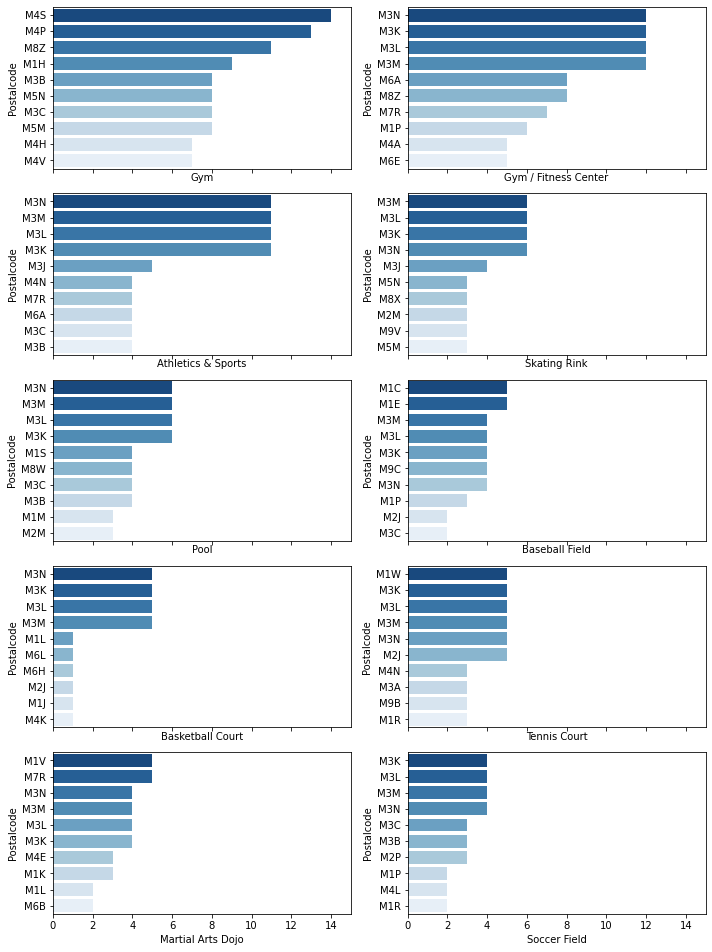

In [42]:
# for better plots use postalcode instead of neighborhood

fig, axes =plt.subplots(5, 2, figsize=(10,5.33*2.5), sharex=True)
axes = axes.flatten()

for ax, category in zip(axes, venue_top10_sport.index.values.tolist()[0:10]):
    data = venue_counts_sport_new[[category]].sort_values([category], ascending=False)[0:10]
    pal = sns.color_palette("Blues", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))
plt.xlim((0,15))
plt.tight_layout()
plt.show();

### Cluster Neighborhoods

#### Create a data frame with the total count of sport venues for each neighborhood

In [43]:
Toronto_grouped_sport_count= Toronto_onehot_sport.groupby('Neighborhood').sum().reset_index()
# create a new column which has the sum of all columns for each row
Toronto_grouped_sport_count['# of sport venues']=Toronto_grouped_sport_count.sum(axis=1)
# drop all other columns
Toronto_grouped_sport_count.drop(sport_categories,axis=1,inplace=True)
Toronto_grouped_sport_count.head()

,Neighborhood,# of sport venues
0,Agincourt,22
1,"Alderwood, Long Branch",17
2,"Bathurst Manor, Wilson Heights, Downsview North",13
3,Bayview Village,8
4,"Bedford Park, Lawrence Manor East",25


#### Create a data frame with the total count of shopping venues for each neighborhood

In [44]:
Toronto_grouped_shop_count= Toronto_onehot_shop[['Neighborhood','Shopping Mall', 'Shopping Plaza']].groupby('Neighborhood').sum().reset_index()
# create a new column which has the sum of all columns for each row
Toronto_grouped_shop_count['# of shopping venues']=Toronto_grouped_shop_count.sum(axis=1)
# drop all other columns
Toronto_grouped_shop_count.drop(['Shopping Mall', 'Shopping Plaza'],axis=1,inplace=True)
Toronto_grouped_shop_count.head()

,Neighborhood,# of shopping venues
0,Agincourt,5
1,"Alderwood, Long Branch",3
2,"Bathurst Manor, Wilson Heights, Downsview North",1
3,Bayview Village,4
4,Berczy Park,2


#### Create a data frame with the total count of Sporting Goods Shop for each  Neighborhood

In [45]:
Toronto_grouped_SportGoodsShop_count= Toronto_onehot_shop[['Neighborhood','Sporting Goods Shop']].groupby('Neighborhood').sum().reset_index()
# create a new column which has the sum of all columns for each row
Toronto_grouped_SportGoodsShop_count.rename({'Sporting Goods Shop':'# of Sporting Goods Shop'},axis=1,inplace=True)
Toronto_grouped_SportGoodsShop_count.head()

,Neighborhood,# of Sporting Goods Shop
0,Agincourt,1
1,"Alderwood, Long Branch",0
2,"Bathurst Manor, Wilson Heights, Downsview North",0
3,Bayview Village,0
4,Berczy Park,0


Combine the previous data frames

In [46]:
#Toronto_grouped_sport.merge(Toronto_grouped_shop, on='Neighborhood')
Toronto_merged_sport_shop=Toronto_grouped_sport_count.merge(Toronto_grouped_shop_count, on='Neighborhood').merge(Toronto_grouped_SportGoodsShop_count, on='Neighborhood')
Toronto_merged_sport_shop.head()

,Neighborhood,# of sport venues,# of shopping venues,# of Sporting Goods Shop
0,Agincourt,22,5,1
1,"Alderwood, Long Branch",17,3,0
2,"Bathurst Manor, Wilson Heights, Downsview North",13,1,0
3,Bayview Village,8,4,0
4,Berczy Park,8,2,0


### Remove the neighborhoods with one or more sporting goods shop from the dataframe

In [47]:
Toronto_merged_sport_shop.drop(Toronto_merged_sport_shop[Toronto_merged_sport_shop['# of Sporting Goods Shop']!=0].index,inplace=True)
# drop the 'Sporting Goods Shop' column
Toronto_merged_sport_shop.drop('# of Sporting Goods Shop',axis=1,inplace=True)
Toronto_merged_sport_shop.head()

,Neighborhood,# of sport venues,# of shopping venues
1,"Alderwood, Long Branch",17,3
2,"Bathurst Manor, Wilson Heights, Downsview North",13,1
3,Bayview Village,8,4
4,Berczy Park,8,2
5,"Birch Cliff, Cliffside West",17,1


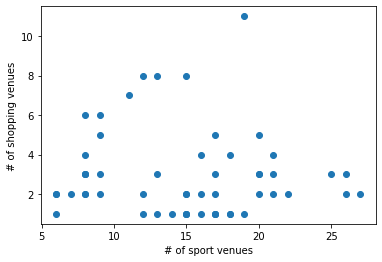

In [48]:
# visualize the data with a scatter plot
plt.scatter(x=Toronto_merged_sport_shop['# of sport venues'],y=Toronto_merged_sport_shop['# of shopping venues'])
plt.xlabel("# of sport venues")
plt.ylabel("# of shopping venues")
plt.show()

### Run *k*-means to count Neighborhoods for each cluster label for variable cluster size

In [49]:
Toronto_grouped_clustering = Toronto_merged_sport_shop.drop('Neighborhood', 1)

#### Determine the optimal number of clusters for k-means clustering

**The Elbow Method** - calculate the sum of squared distances of samples to their closest cluster center for different values of k. The value of k after which there is no siginificant decrease in sum of squared distances is choosen.

In [50]:
sum_of_squared_distances = []
K = range(2,20)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(Toronto_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

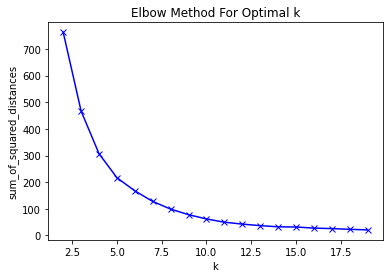

In [51]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

#### Let's set number of clusters = 7

In [52]:
# set number of clusters
kclusters = 7

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=50).fit(Toronto_grouped_clustering)

print(Counter(kmeans.labels_))

Counter({3: 15, 5: 13, 1: 10, 2: 8, 4: 4, 6: 4, 0: 1})


#### Let's create a new dataframe that includes the cluster as well as the neighborhood information

In [53]:
# add clustering labels
try:
    Toronto_merged_sport_shop.drop('Cluster Labels', axis=1)
except:
    Toronto_merged_sport_shop.insert(0, 'Cluster Labels', kmeans.labels_)

In [54]:
Toronto_merged_sport_shop

,Cluster Labels,Neighborhood,# of sport venues,# of shopping venues
1,5,"Alderwood, Long Branch",17,3
2,1,"Bathurst Manor, Wilson Heights, Downsview North",13,1
3,3,Bayview Village,8,4
4,3,Berczy Park,8,2
5,5,"Birch Cliff, Cliffside West",17,1
7,4,Canada Post Gateway Processing Centre,26,2
9,6,Central Bay Street,12,8
10,5,Christie,17,2
11,6,Church and Wellesley,11,7
12,5,"Clarks Corners, Tam O'Shanter, Sullivan",16,4


In [55]:
# merge neighborhoods_venues_sorted with Toronto_data to add latitude/longitude for each neighborhood
Toronto_merged_sport_shop = Toronto_merged_sport_shop.join(df.set_index('Neighborhood'), on='Neighborhood')
Toronto_merged_sport_shop.dropna(inplace=True)

### Finally, let's visualize the resulting clusters

In [56]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged_sport_shop['Latitude'], Toronto_merged_sport_shop['Longitude'], Toronto_merged_sport_shop['Neighborhood'], Toronto_merged_sport_shop['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Results

#### Cluster 1

In [57]:
cluster_1 = Toronto_merged_sport_shop.loc[Toronto_merged_sport_shop['Cluster Labels'] == 0, Toronto_merged_sport_shop.columns[1:12]]
cluster_1.head()

,Neighborhood,# of sport venues,# of shopping venues,Postalcode,Borough,Latitude,Longitude
41,"Milliken, Agincourt North, Steeles East, L'Amo...",19,11,M1V,Scarborough,43.815252,-79.284577


#### Cluster 2

In [58]:
cluster_2 = Toronto_merged_sport_shop.loc[Toronto_merged_sport_shop['Cluster Labels'] == 1, Toronto_merged_sport_shop.columns[1:12]]
cluster_2

,Neighborhood,# of sport venues,# of shopping venues,Postalcode,Borough,Latitude,Longitude
2,"Bathurst Manor, Wilson Heights, Downsview North",13,1,M3H,North York,43.754328,-79.442259
19,"Dufferin, Dovercourt Village",15,2,M6H,West Toronto,43.669005,-79.442259
32,"Humberlea, Emery",15,1,M9M,North York,43.724766,-79.532242
36,"Kensington Market, Chinatown, Grange Park",13,3,M5T,Downtown Toronto,43.653206,-79.400049
40,"Malvern, Rouge",14,1,M1B,Scarborough,43.806686,-79.194353
56,"South Steeles, Silverstone, Humbergate, Jamest...",12,2,M9V,Etobicoke,43.739416,-79.588437
61,Studio District,15,1,M4M,East Toronto,43.659526,-79.340923
66,"The Kingsway, Montgomery Road, Old Mill North",12,1,M8X,Etobicoke,43.653654,-79.506944
72,Westmount,15,1,M9P,Etobicoke,43.696319,-79.532242


#### Cluster 3

In [59]:
cluster_3 = Toronto_merged_sport_shop.loc[Toronto_merged_sport_shop['Cluster Labels'] == 2, Toronto_merged_sport_shop.columns[1:12]]
cluster_3.head()

,Neighborhood,# of sport venues,# of shopping venues,Postalcode,Borough,Latitude,Longitude
22,"Fairview, Henry Farm, Oriole",21,4,M2J,North York,43.778517,-79.346556
26,Glencairn,20,3,M6B,North York,43.709577,-79.445073
37,"Kingsview Village, St. Phillips, Martin Grove ...",21,2,M9R,Etobicoke,43.688905,-79.554724
38,"Lawrence Manor, Lawrence Heights",22,2,M6A,North York,43.718518,-79.464763
48,Parkwoods,20,5,M3A,North York,43.753259,-79.329656


#### Cluster 4

In [60]:
cluster_4 = Toronto_merged_sport_shop.loc[Toronto_merged_sport_shop['Cluster Labels'] == 3, Toronto_merged_sport_shop.columns[1:12]]
cluster_4.head()

,Neighborhood,# of sport venues,# of shopping venues,Postalcode,Borough,Latitude,Longitude
3,Bayview Village,8,4,M2K,North York,43.786947,-79.385975
4,Berczy Park,8,2,M5E,Downtown Toronto,43.644771,-79.373306
13,"Commerce Court, Victoria Hotel",6,2,M5L,Downtown Toronto,43.648198,-79.379817
23,"First Canadian Place, Underground city",6,2,M5X,Downtown Toronto,43.648429,-79.382280
25,"Garden District, Ryerson",9,6,M5B,Downtown Toronto,43.657162,-79.378937


#### Cluster 5

In [61]:
cluster_5 = Toronto_merged_sport_shop.loc[Toronto_merged_sport_shop['Cluster Labels'] == 4, Toronto_merged_sport_shop.columns[1:12]]
cluster_5.head()

,Neighborhood,# of sport venues,# of shopping venues,Postalcode,Borough,Latitude,Longitude
7,Canada Post Gateway Processing Centre,26,2,M7R,Mississauga,43.636966,-79.615819
42,"Mimico NW, The Queensway West, South of Bloor,...",26,3,M8Z,Etobicoke,43.628841,-79.520999
74,"Wexford, Maryvale",25,3,M1R,Scarborough,43.750072,-79.295849
78,York Mills West,27,2,M2P,North York,43.752758,-79.400049


#### Cluster 6

In [62]:
cluster_6 = Toronto_merged_sport_shop.loc[Toronto_merged_sport_shop['Cluster Labels'] == 5, Toronto_merged_sport_shop.columns[1:12]]
cluster_6.head()

,Neighborhood,# of sport venues,# of shopping venues,Postalcode,Borough,Latitude,Longitude
1,"Alderwood, Long Branch",17,3,M8W,Etobicoke,43.602414,-79.543484
5,"Birch Cliff, Cliffside West",17,1,M1N,Scarborough,43.692657,-79.264848
10,Christie,17,2,M6G,Downtown Toronto,43.669542,-79.422564
12,"Clarks Corners, Tam O'Shanter, Sullivan",16,4,M1T,Scarborough,43.781638,-79.304302
21,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",19,1,M9C,Etobicoke,43.643515,-79.577201


#### Cluster 7

In [63]:
cluster_7 = Toronto_merged_sport_shop.loc[Toronto_merged_sport_shop['Cluster Labels'] == 6, Toronto_merged_sport_shop.columns[1:12]]
cluster_7.head()

,Neighborhood,# of sport venues,# of shopping venues,Postalcode,Borough,Latitude,Longitude
9,Central Bay Street,12,8,M5G,Downtown Toronto,43.657952,-79.387383
11,Church and Wellesley,11,7,M4Y,Downtown Toronto,43.665860,-79.383160
49,"Queen's Park, Ontario Provincial Government",13,8,M7A,Downtown Toronto,43.662301,-79.389494
69,"University of Toronto, Harbord",15,8,M5S,Downtown Toronto,43.662696,-79.400049


### Show the results of clustering on the scatter plot

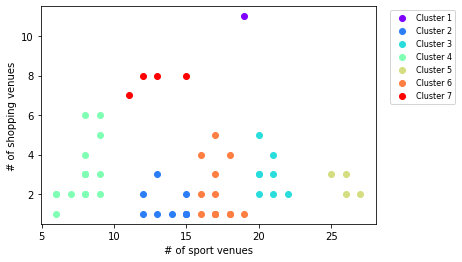

In [64]:
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

a=plt.scatter(x=cluster_1['# of sport venues'],y=cluster_1['# of shopping venues'],c=rainbow[0])
b=plt.scatter(x=cluster_2['# of sport venues'],y=cluster_2['# of shopping venues'],c=rainbow[1])
c=plt.scatter(x=cluster_3['# of sport venues'],y=cluster_3['# of shopping venues'],c=rainbow[2])
d=plt.scatter(x=cluster_4['# of sport venues'],y=cluster_4['# of shopping venues'],c=rainbow[3])
e=plt.scatter(x=cluster_5['# of sport venues'],y=cluster_5['# of shopping venues'],c=rainbow[4])
f=plt.scatter(x=cluster_6['# of sport venues'],y=cluster_6['# of shopping venues'],c=rainbow[5])
g=plt.scatter(x=cluster_7['# of sport venues'],y=cluster_7['# of shopping venues'],c=rainbow[6])

plt.xlabel("# of sport venues")
plt.ylabel("# of shopping venues")
plt.legend((a, b, c, d, e, f, g),
           ('Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7'),
           scatterpoints=1,
           loc='upper right',
           ncol=1,
           fontsize=8,
           bbox_to_anchor=(1.25, 1))

In [65]:
# let's visualize the desired cluster on the map
# select a cluster
cluster=7
Selected=Toronto_merged_sport_shop[Toronto_merged_sport_shop['Cluster Labels']==cluster-1]
Selected

,Cluster Labels,Neighborhood,# of sport venues,# of shopping venues,Postalcode,Borough,Latitude,Longitude
9,6,Central Bay Street,12,8,M5G,Downtown Toronto,43.657952,-79.387383
11,6,Church and Wellesley,11,7,M4Y,Downtown Toronto,43.665860,-79.383160
49,6,"Queen's Park, Ontario Provincial Government",13,8,M7A,Downtown Toronto,43.662301,-79.389494
69,6,"University of Toronto, Harbord",15,8,M5S,Downtown Toronto,43.662696,-79.400049


### Show the optimum locations on the map

In [66]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi in zip(Selected['Latitude'], Selected['Longitude'], Selected['Neighborhood']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters